In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
import os
from IPython.display import SVG, display
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Get and clean the Data

In [2]:
def preprocess_dataframes(urls, variable_names):
    if len(urls) != len(variable_names):
        raise ValueError("The number of URLs and variable names should match.")

    # Loop over each url
    for i, url in enumerate(urls):
        print(f"Processing DataFrame {variable_names[i]}:")

        # Read the data
        data_raw = pd.read_csv(url)

        # Check for missing values
        missing_values = data_raw.isnull().sum()
        print('Missing values:\n', missing_values)

        # Check for duplicates
        duplicates = data_raw.duplicated().sum()
        print('Number of duplicate rows:', duplicates, '\n')

        # Check for duplicate time stamps
        duplicate_times = data_raw['Time[s]'].duplicated().sum()
        print('Number of duplicate time stamp rows:', duplicate_times, '\n')

        total_rows = len(data_raw)

        # Remove duplicate rows based on "Time[s]", keeping the first instance
        data = data_raw.drop_duplicates(subset='Time[s]', keep='first')

        # Count the total number of rows after removing duplicates
        total_rows_after_removal = len(data)

        # Calculate the number of rows removed
        rows_removed = total_rows - total_rows_after_removal

        print('Number of rows removed because of duplicate time stamps:', rows_removed, '\n')

        # Store the cleaned data under the same variable name just without the raw extension
        globals()[variable_names[i]] = data

In [3]:
urls = [
    'https://raw.githubusercontent.com/JPyschny/EIM_Autoencoder/main/2023-06-30_13-17-03_Test%20run%20unloaded.csv',
    'https://raw.githubusercontent.com/JPyschny/EIM_Autoencoder/main/2023-06-30_14-43-16_Test%20run%20loaded.csv'
]

variable_names = ['testRunUnloaded', 'testRunLoaded']

preprocess_dataframes(urls, variable_names)

Processing DataFrame testRunUnloaded:
Missing values:
 Time[s]             0
RateRoll[deg/s]     0
RatePitch[deg/s]    0
RateYaw[deg/s]      0
AccX[m/s^2]         0
AccY[m/s^2]         0
AccZ[m/s^2]         0
Torque[Ncm]         0
dtype: int64
Number of duplicate rows: 0 

Number of duplicate time stamp rows: 772 

Number of rows removed because of duplicate time stamps: 772 

Processing DataFrame testRunLoaded:
Missing values:
 Time[s]             0
RateRoll[deg/s]     0
RatePitch[deg/s]    0
RateYaw[deg/s]      0
AccX[m/s^2]         0
AccY[m/s^2]         0
AccZ[m/s^2]         0
Torque[Ncm]         0
dtype: int64
Number of duplicate rows: 0 

Number of duplicate time stamp rows: 702 

Number of rows removed because of duplicate time stamps: 702 



In [4]:
def plot(df, x_min, x_max, title_string, save_directory):
    
    translations = {
        "RateRoll[deg/s]": "Rollrate",
        "RatePitch[deg/s]": "Nickrate",
        "RateYaw[deg/s]": "Gierrate",
        "AccX[m/s^2]": "X-Beschl.",
        "AccY[m/s^2]": "Y-Beschl.",
        "AccZ[m/s^2]": "Z-Beschl.",
        "Torque[Ncm]": "Drehmoment"
    }

    color_scheme = {
        "RateRoll[deg/s]": "tab:blue",
        "RatePitch[deg/s]": "tab:orange",
        "RateYaw[deg/s]": "tab:green",
        "AccX[m/s^2]": "tab:blue",
        "AccY[m/s^2]": "tab:orange",
        "AccZ[m/s^2]": "tab:green",
        "Torque[Ncm]": "tab:blue",
    }
    
    # Create subplots
    fig, axs = plt.subplots(4, 1, figsize=(16, 9), sharex=True)
    
    # First subplot: Accelerations over time
    accelerations = ['AccX[m/s^2]', 'AccY[m/s^2]', 'AccZ[m/s^2]']
    zorders = [2, 1, 3] # Z-Beschl.+AE on the front, then X-Beschl.+AE and then Y-Beschl.+AE
    for acc, z in zip(accelerations, zorders):
        sns.lineplot(data=df, x='Time[s]', y=acc, ax=axs[0], label=translations[acc], color=color_scheme[acc], zorder=z)
    axs[0].set_ylabel('Beschleunigung [m/s^2]')

    # Second subplot: Roll and pitch rates over time
    rates = ['RateRoll[deg/s]', 'RatePitch[deg/s]']
    zorders = [2, 1]
    for rate, z in zip(rates, zorders):
        sns.lineplot(data=df, x='Time[s]', y=rate, ax=axs[1], label=translations[rate], color=color_scheme[rate], zorder=z)
    axs[1].set_ylabel('Drehrate [°/s]')

    # Third subplot: Yaw rate over time
    rate = 'RateYaw[deg/s]'
    sns.lineplot(data=df, x='Time[s]', y=rate, ax=axs[2], label=translations[rate], color=color_scheme[rate])
    axs[2].set_ylabel('Drehrate [°/s]')

    # Fourth subplot: Torque over time
    torque = 'Torque[Ncm]'
    sns.lineplot(data=df, x='Time[s]', y=torque, ax=axs[3], label=translations[torque], color=color_scheme[torque])
    axs[3].set_ylabel('Drehmoment [Ncm]')
    axs[3].set_xlabel('Zeit [s]')

    # Update the legends of subplots
    for ax in axs:
        ax.legend(loc='upper left')

    # Adjust spacing between subplots
    plt.subplots_adjust(hspace=0.1)
    
    # Add grid line
    for ax in axs:
        ax.grid(True, which='both', linestyle='-', linewidth=0.25)
    
        # Add minor ticks
        ax.minorticks_on()
    
        # Set the y-axis ticks to be coarser
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        
    # Set x-axis limits if provided
    x_min = df['Time[s]'].min()
    x_max = df['Time[s]'].max()
    for ax in axs:
        ax.set_xlim([x_min, x_max])

    # Save the figure as SVG if save_directory is provided
    if title_string and save_directory is not None:
        # Set the title
        fig.suptitle(title_string, fontsize=14, y=0.92)
        
        # Create the directory if it doesn't exist
        os.makedirs(save_directory, exist_ok=True)
        
        # Generate the file path and save the figure as SVG
        file_path = os.path.join(save_directory, f"{title_string}.svg")
        plt.savefig(file_path, format='svg', dpi=300, transparent=True)

    # Show the plot
    plt.show()

## Visualize Training Data 

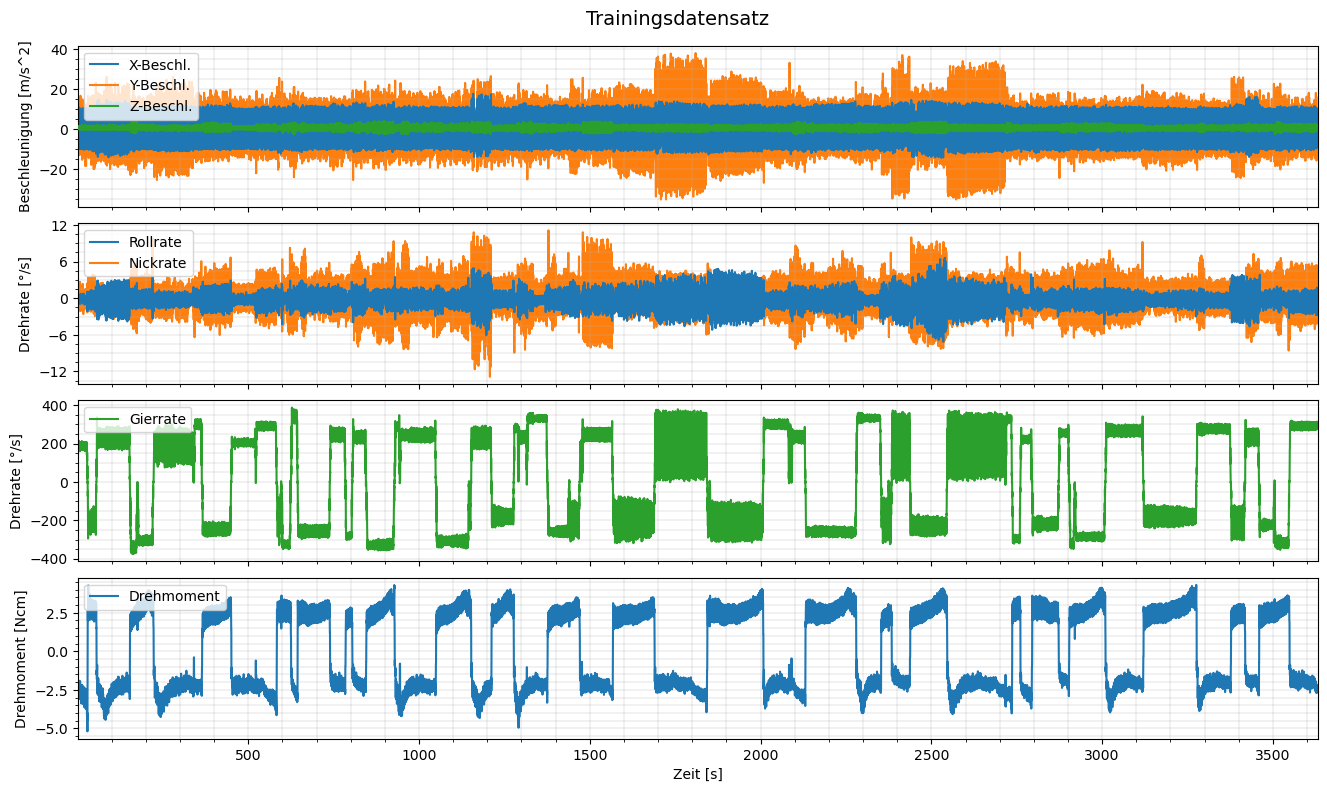

In [9]:
plot(testRunUnloaded, 0, 60*60, 'Trainingsdatensatz', 'Trainingsdatensatz')

# Data Preprocessing

In [10]:
def preprocess_data(df, sequence_length):
    # Normalize the data
    training_mean = df.mean()
    training_std = df.std()
    df_training_value = (df - training_mean) / training_std
    print("Number of training samples:", len(df_training_value))

    # Create sequences
    def create_sequences(values, sequence_length=sequence_length):
        output = []
        for i in range(len(values) - sequence_length + 1):
            output.append(values[i : (i + sequence_length)])
        return np.stack(output)

    x_train = create_sequences(df_training_value.values)
    print("Training input shape: ", x_train.shape)
    
    # Shuffle training data
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    x_train = x_train[indices]

    return x_train, training_mean, training_std

# Example usage:
TIME_STEPS = 8
x_train, training_mean, training_std = preprocess_data(testRunUnloaded, TIME_STEPS)
n_features = x_train.shape[2]  # the number of features
print("Number of features: ", n_features)

Number of training samples: 38618
Training input shape:  (38611, 8, 8)
Number of features:  8


In [11]:
def inverse_preprocess(sequence_data, training_mean, training_std, columns):
    # Consider only the first element of each sequence
    first_elements = sequence_data[:, 0, :]
    # Inverse the normalization
    inverse_data = first_elements * training_std.values + training_mean.values
    # Convert to DataFrame
    df_inverse = pd.DataFrame(inverse_data, columns=columns)
    return df_inverse

# Inverse preprocess sequence data
# inverse_sequence_df = inverse_preprocess(x_train, training_mean, training_std, testRunUnloaded.columns)
# inverse_sequence_df

# Build the Model

## 1. Keras Example Model

In [ ]:
# Build the model
model_V1 = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], n_features)),
        layers.Conv1D(filters=32, kernel_size=7, padding='same', strides=2, activation='relu'),
        layers.Dropout(rate=0.2),
        layers.Conv1D(filters=16, kernel_size=7, padding='same', strides=2, activation='relu'),
        layers.Conv1DTranspose(filters=16, kernel_size=7, padding='same', strides=2, activation='relu'),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(filters=32, kernel_size=7, padding='same', strides=2, activation='relu'),
        layers.Conv1DTranspose(filters=n_features, kernel_size=7, padding='same'),  # change number of filters to n_features
    ]
)
model_V1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')
model_V1.summary()

In [ ]:
# Train the model
history = model_V1.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
    ],
)

# Get train MAE loss.
x_train_pred = model_V1.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

# Get reconstruction loss threshold.
threshold_V1 = np.max(train_mae_loss)
print('Reconstruction error threshold: ', threshold_V1)

In [ ]:
# Plot the training loss and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.show()

In [ ]:
# Save the model
directory = 'models'
model_V1.save(os.path.join(directory, "model_V1.h5"))

## Fine-tuned Model V2

In [ ]:
# Fine-tuned model
model_V2 = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], n_features)),
        layers.Conv1D(filters=64, kernel_size=7, padding='same', strides=1, activation='relu'),
        layers.Dropout(rate=0.2),
        layers.Conv1D(filters=32, kernel_size=7, padding='same', strides=1, activation='relu'),
        layers.Conv1D(filters=16, kernel_size=7, padding='same', strides=1, activation='relu'),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(filters=16, kernel_size=7, padding='same', strides=1, activation='relu'),
        layers.Conv1DTranspose(filters=32, kernel_size=7, padding='same', strides=1, activation='relu'),
        layers.Conv1DTranspose(filters=64, kernel_size=7, padding='same', strides=1, activation='relu'),
        layers.Conv1DTranspose(filters=n_features, kernel_size=7, padding='same'),
    ]
)
model_V2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')
model_V2.summary()

In [ ]:
# Train the model_V2
history = model_V2.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
    ],
)

# Get train MAE loss.
x_train_pred = model_V2.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

# Get reconstruction loss threshold.
threshold_V2 = np.max(train_mae_loss)
print('Reconstruction error threshold: ', threshold_V2)

In [ ]:
plt.figure(figsize=(19/2, 9/2))

# Plot the training loss and validation loss
plt.plot(history.history["loss"], label="Trainingsverlust")
plt.plot(history.history["val_loss"], label="Validierungsverlust")
plt.xlabel('Epochen')
plt.ylabel('Verlust')
plt.title('Trainingsverlauf')
plt.legend()
plt.xlim([0, len(history.history["loss"])-1])
plt.tight_layout()

# Generate the file path and save the figure as SVG
file_path = os.path.join('models', f"Losses_model_V2.svg")

# Set dpi and adjust transparency settings
plt.savefig(file_path, format='svg', dpi=300, transparent=True)

# Show the plot
plt.show()

In [ ]:
# Save the model
directory = 'models'
model_V2.save(os.path.join(directory, "model_V2.h5"))

## Fine-tuned Model V3

In [ ]:
model_V3 = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], n_features)),
        layers.Conv1D(filters=128, kernel_size=8, padding='same', strides=1, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(rate=0.1),
        layers.Conv1D(filters=64, kernel_size=8, padding='same', strides=1, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(rate=0.1),
        layers.Conv1D(filters=32, kernel_size=8, padding='same', strides=1, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(rate=0.1),
        layers.Conv1DTranspose(filters=32, kernel_size=8, padding='same', strides=1, activation='relu'),
        layers.BatchNormalization(),
        layers.Conv1DTranspose(filters=64, kernel_size=8, padding='same', strides=1, activation='relu'),
        layers.BatchNormalization(),
        layers.Conv1DTranspose(filters=128, kernel_size=8, padding='same', strides=1, activation='relu'),
        layers.BatchNormalization(),
        layers.Conv1DTranspose(filters=n_features, kernel_size=8, padding='same'),
    ]
)
model_V3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')
# model_V3.summary()

In [ ]:
# Train the model_V3
history = model_V3.fit(
    x_train,
    x_train,
    epochs=300,
    batch_size=128*10,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)
    ],
)

# Get train MAE loss
x_train_pred = model_V3.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

# Get reconstruction loss threshold
threshold_V3 = np.max(train_mae_loss)
print('Reconstruction error threshold: ', threshold_V3)

In [ ]:
plt.figure(figsize=(19/2, 9/2))

# Plot the training loss and validation loss
plt.plot(history.history["loss"], label="Trainingsverlust")
plt.plot(history.history["val_loss"], label="Validierungsverlust")
plt.xlabel('Epochen')
plt.ylabel('Verlust (MSE)')
plt.title('Trainingsverlauf')
plt.legend()
plt.xlim([0, len(history.history["loss"])-1])
plt.ylim([0, round(max(history.history["val_loss"]),2)])
plt.grid(True)
plt.tight_layout()

# Generate the file path and save the figure as SVG
file_path = os.path.join('models', f"Losses_model_V3.svg")

# Set dpi and adjust transparency settings
plt.savefig(file_path, format='svg', dpi=300, transparent=True)

# Show the plot
plt.show()

In [ ]:
# Save the model
directory = 'models'
model_V3.save(os.path.join(directory, "model_V3.h5"))

# Reconstruct Predictions

Load the most recent model:

In [12]:
# Load the model
directory = 'models'
loadedModel = keras.models.load_model(os.path.join(directory, "model_V3.h5"))

In [13]:
def generate_predictions(model, input_data, start_time, end_time, normalization_mean, normalization_std, sequence_length):
    selected_input_data = input_data[(input_data['Time[s]'] >= start_time) & (input_data['Time[s]'] <= end_time)]
    
    # Get column name sof the input df
    column_names = input_data.columns
    
    def preprocess_test_data(df, training_mean, training_std, sequence_length):
        # Normalize the data
        df_training_value = (df - training_mean) / training_std
        print("Number of test samples:", len(df_training_value))

        # Create sequences
        def create_sequences(values, sequence_length=sequence_length):
            output = []
            for i in range(len(values) - sequence_length + 1):
                output.append(values[i : (i + sequence_length)])
            return np.stack(output)

        test_sequences = create_sequences(df_training_value.values)

        return test_sequences

    # Preprocess test data
    test_sequences = preprocess_test_data(selected_input_data, training_mean, training_std, sequence_length)
    
    # Make predictions
    raw_predictions = model.predict(test_sequences)

    # Reshape the predicted data to 2D (flattening the timesteps and features dimensions)
    flattened_predictions = raw_predictions.reshape(-1, raw_predictions.shape[-1])
    flattened_predictions.shape[0]/sequence_length

    # De-normalize the predicted data
    denormalized_predictions = flattened_predictions * training_std.values + training_mean.values

    # Convert the predicted data to a DataFrame
    predicted_df = pd.DataFrame(denormalized_predictions, columns=column_names)
    
    # Trim the selected_input_data to contain only rows with predictions
    original_df = selected_input_data.iloc[4:-3]

    # Set the "Time[s]" column to match the timesteps of the original data
    time_values = original_df['Time[s]'].values

    # Trim the original df to match the shape of the predictions
    predicted_df['Time[s]'] = np.repeat(time_values, sequence_length)[:len(predicted_df)]
    
    # Finally, reset the index for both dataframes so they align
    original_df = original_df.reset_index(drop=True)
    predicted_df = predicted_df.reset_index(drop=True)

    return original_df, predicted_df

In [14]:
x_min = 0
x_max = 20

original_df, predicted_df = generate_predictions(loadedModel, testRunUnloaded, x_min, x_max, training_mean, training_std, TIME_STEPS)

Number of test samples: 209
7/7 [==============================] - 0s 2ms/step


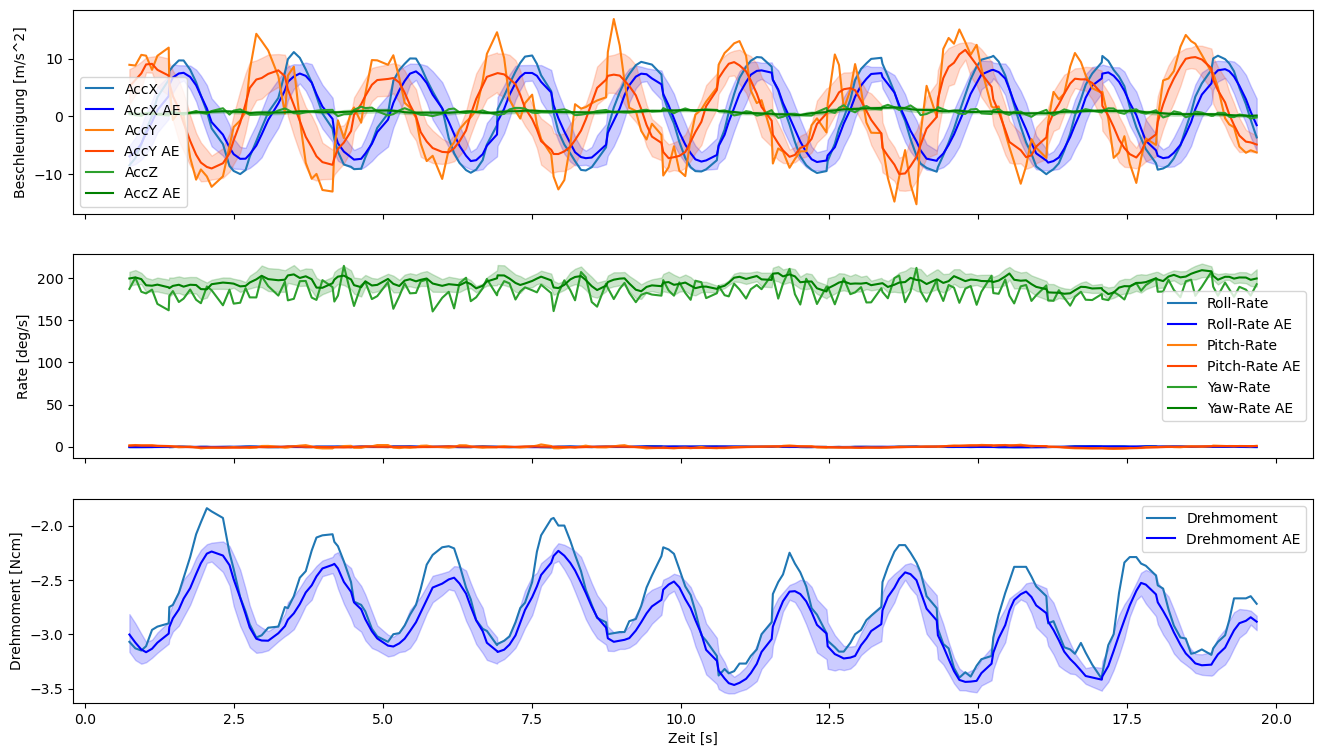

In [15]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 9), sharex=True)

# First subplot: Accelerations over time
sns.lineplot(data=original_df, x='Time[s]', y='AccX[m/s^2]', ax=ax1, label='AccX')
sns.lineplot(data=predicted_df, x='Time[s]', y='AccX[m/s^2]', ax=ax1, label='AccX AE', color='blue')
sns.lineplot(data=original_df, x='Time[s]', y='AccY[m/s^2]', ax=ax1, label='AccY')
sns.lineplot(data=predicted_df, x='Time[s]', y='AccY[m/s^2]', ax=ax1, label='AccY AE', color='orangered')
sns.lineplot(data=original_df, x='Time[s]', y='AccZ[m/s^2]', ax=ax1, label='AccZ')
sns.lineplot(data=predicted_df, x='Time[s]', y='AccZ[m/s^2]', ax=ax1, label='AccZ AE', color='green')
ax1.set_ylabel('Beschleunigung [m/s^2]')

# Second subplot: Roll, pitch and yaw rates over time
sns.lineplot(data=original_df, x='Time[s]', y='RateRoll[deg/s]', ax=ax2, label='Roll-Rate')
sns.lineplot(data=predicted_df, x='Time[s]', y='RateRoll[deg/s]', ax=ax2, label='Roll-Rate AE', color='blue')
sns.lineplot(data=original_df, x='Time[s]', y='RatePitch[deg/s]', ax=ax2, label='Pitch-Rate')
sns.lineplot(data=predicted_df, x='Time[s]', y='RatePitch[deg/s]', ax=ax2, label='Pitch-Rate AE', color='orangered')
sns.lineplot(data=original_df, x='Time[s]', y='RateYaw[deg/s]', ax=ax2, label='Yaw-Rate')
sns.lineplot(data=predicted_df, x='Time[s]', y='RateYaw[deg/s]', ax=ax2, label='Yaw-Rate AE', color='green')
ax2.set_ylabel('Rate [deg/s]')

# Torque over time
sns.lineplot(data=original_df, x='Time[s]', y='Torque[Ncm]', ax=ax3, label='Drehmoment')
sns.lineplot(data=predicted_df, x='Time[s]', y='Torque[Ncm]', ax=ax3, label='Drehmoment AE', color='blue')
ax3.set_ylabel('Drehmoment [Ncm]')
ax3.set_xlabel('Zeit [s]')

plt.show()

# Make Predictions on Training Data Set

## Examplery Predictions on training data

In [16]:
x_min = 0
x_max = 60*60

# Make predictions on training set
original_train_df, predicted_train_df = generate_predictions(loadedModel, testRunUnloaded, x_min, x_max, training_mean, training_std, TIME_STEPS)

Number of test samples: 38306
1197/1197 [==============================] - 2s 2ms/step


### MAE Function

In [17]:
def calculate_mae_between_dfs(original_df, predicted_df, sequence_length):

    # Copy predicted df
    predicted_df_grouped = predicted_df.copy()

    # Create a new column 'group' that assigns group numbers to each 8 rows
    predicted_df_grouped['group'] = np.arange(len(predicted_df)) // sequence_length

    # Then group by this new column and calculate the mean
    predicted_df_grouped = predicted_df_grouped.groupby('group').mean()

    # Calculate the absolute error for each feature and each row except 'Time[s]'
    mae_df = (original_df.drop(columns=['Time[s]']) - predicted_df_grouped.drop(columns=['Time[s]'])).abs()

    # Add the 'Time[s]' column back from the original dataframe
    mae_df = pd.concat([original_df['Time[s]'], mae_df], axis=1)

    return mae_df, predicted_df_grouped

# Calculate MAE and Define Suitable Thresholds

Since the data are divided into sequences, the MAE is calculated for each sequence. That is, ${\hat{x}}_{ij}$ refers to the reconstructed values in the sequence (with a sequence length of n=8), while $x_i$ refers to the single value in the input data. The MAE is then calculated for every $i$-th sequence.

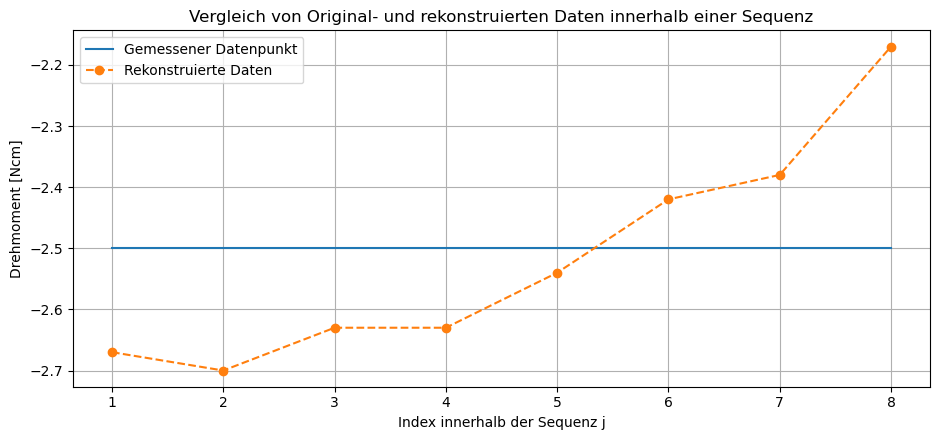

In [18]:
# Define the sequence length and the data points
n = 8
x_i = -2.50
x_hat_ij = np.array([-2.67, -2.70, -2.63, -2.63, -2.54, -2.42, -2.38, -2.17])

# Generate a sequence of data points for the original and reconstructed data
original_data = np.full((n,), x_i)
reconstructed_data = x_hat_ij

# Generate a sequence of indices
indices = np.arange(n)+1

# Create the plot
plt.figure(figsize=(19/2, 9/2))
plt.plot(indices, original_data, label='Gemessener Datenpunkt')
plt.plot(indices, reconstructed_data, marker='o', linestyle='--', label='Rekonstruierte Daten')

# Add labels and legend
plt.xlabel('Index innerhalb der Sequenz j')
plt.ylabel('Drehmoment [Ncm]')
plt.legend()
plt.title('Vergleich von Original- und rekonstruierten Daten innerhalb einer Sequenz')
plt.grid(True)
plt.tight_layout()

# Generate the file path and save the figure as SVG
file_path = os.path.join('Anomalie-Plots', f"Zeit_Sequenz.svg")

# Set dpi and adjust transparency settings
plt.savefig(file_path, format='svg', dpi=300, transparent=True)

plt.show()

Compute a threshold for each feature based on the full nominal operation data:

In [19]:
mae_train_df, predicted_df_grouped = calculate_mae_between_dfs(original_train_df, predicted_train_df, TIME_STEPS)
mae_train_df

Time[s]  RateRoll[deg/s]  RatePitch[deg/s]  RateYaw[deg/s]  \
0         0.75         0.121385          0.267702       12.369665   
1         0.85         0.055899          0.547243        0.358594   
2         0.95         0.002721          0.144300       15.005992   
3         1.03         0.181804          0.347776        9.668713   
4         1.13         0.052043          0.440079        4.647477   
...        ...              ...               ...             ...   
38294  3599.37         0.112355          3.369277       14.192380   
38295  3599.43         0.530356          3.090826       12.378641   
38296  3599.50         0.885737          2.089355       13.929207   
38297  3599.60         0.901386          0.801634       20.139045   
38298  3599.71         0.951327          0.712349       20.851271   

       AccX[m/s^2]  AccY[m/s^2]  AccZ[m/s^2]  Torque[Ncm]  
0         1.540653     3.755151     0.312446     0.067045  
1         1.066649     2.497646     0.218100     0.052938  
2         0.133680     3.208723     0.370831     0.009222  
3         0.523714     1.514967     0.095075     0.055421  
4         1.085101     1.039303     0.221305     0.173642  
...            ...          ...          ...          ...  
38294     0.650296     1.403669     1.127926     0.113896  
38295     3.224873     0.867114     0.667470     0.055920  
38296     5.153649     2.188252     0.327801     0.052514  
38297     5.227488     2.089805     0.680742     0.209074  
38298     4.117601     0.559927     1.055070     0.294104  

[38299 rows x 8 columns]

In [20]:
# Define the multipliers for each feature
multipliers = {
    "RateRoll[deg/s]": 5,
    "RatePitch[deg/s]": 5,
    "RateYaw[deg/s]": 3,
    "AccX[m/s^2]": 4,
    "AccY[m/s^2]": 5,
    "AccZ[m/s^2]": 5.5,
    "Torque[Ncm]": 9
}

# Initialize an empty dictionary to store the thresholds
thresholds = {}

# Initialize dictionaries to store mean and std dev
mean_mae = {}
std_mae = {}

# Iterate over each column in mae_train_df (skip the 'Time[s]')
for column in mae_train_df.columns:
    if column != 'Time[s]':
        # Get the multiplier for the current feature
        multiplier = multipliers.get(column, 1)

        # Compute the mean and standard deviation of the MAE for the current feature
        mean_train_mae = mae_train_df[column].mean()
        std_train_mae = mae_train_df[column].std()

        # Store these for later use in plotting
        mean_mae[column] = mean_train_mae
        std_mae[column] = std_train_mae

        # Compute the threshold for the current feature
        threshold = mean_train_mae + multiplier * std_train_mae

        # Store the feature and its threshold in the dictionary
        thresholds[column] = threshold

thresholds

{'RateRoll[deg/s]': 4.858372611361075,
 'RatePitch[deg/s]': 8.873285283082636,
 'RateYaw[deg/s]': 132.34083938011545,
 'AccX[m/s^2]': 9.462730771577313,
 'AccY[m/s^2]': 30.02531770347259,
 'AccZ[m/s^2]': 3.53080468205594,
 'Torque[Ncm]': 1.1870597225059574}

The standardized MAE is the number of standard deviations each MAE value is from the mean. This is calculated as:

In [21]:
# Initialize a new DataFrame to store the standardized MAE values
mae_std_devs = pd.DataFrame()

# Iterate over each column in mae_train_df (skip the 'Time[s]')
for column in mae_train_df.columns:
    if column != 'Time[s]':
        # Compute the standardized MAE for the current feature
        mae_std_devs[column] = (mae_train_df[column] - mean_mae[column]) / std_mae[column]

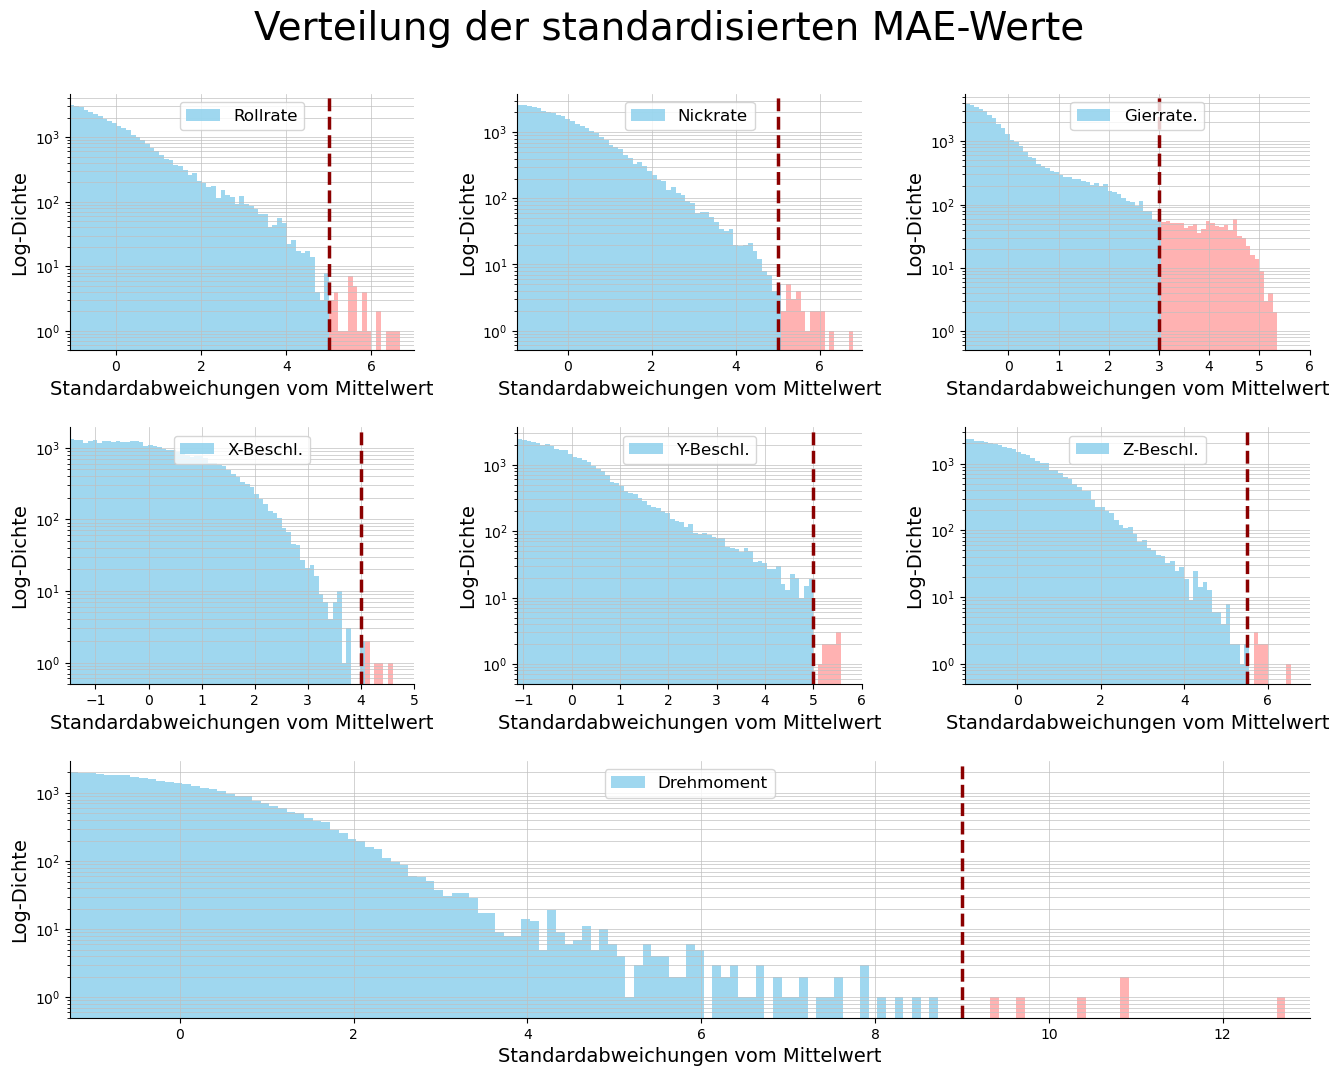

In [22]:
translations = {
    "RateRoll[deg/s]": "Rollrate",
    "RatePitch[deg/s]": "Nickrate",
    "RateYaw[deg/s]": "Gierrate.",
    "AccX[m/s^2]": "X-Beschl.",
    "AccY[m/s^2]": "Y-Beschl.",
    "AccZ[m/s^2]": "Z-Beschl.",
    "Torque[Ncm]": "Drehmoment"
}

# Create subplots with a GridSpec for more flexibility
fig = plt.figure(figsize=(16, 12))
gs = plt.GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)  # Decrease the vertical spacing between the 2nd and 3rd rows

# Define the axes for each subplot
axs = [
    fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]),  # first row
    fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]),  # second row
    fig.add_subplot(gs[2, :])  # third row for Torque
]

# Create histograms with updated settings
for ax, column in zip(axs, mae_train_df.columns[1:]):
    num_bins = 140 if column == "Torque[Ncm]" else 70  # Double the amount of bins for Torque
    
    # Plot the histogram with Seaborn, with log scaled y-axis
    counts, bins, patches = ax.hist(mae_std_devs[column].dropna(), bins=num_bins, log=True, color="skyblue", edgecolor=None, alpha=0.8, label=translations[column])
    
    # Get the threshold in terms of number of standard deviations from the mean
    threshold_std_dev = (thresholds[column] - mean_mae[column]) / std_mae[column]
    
    # Fill the area of the histogram that is beyond the threshold
    for count, bin, patch in zip(counts, bins, patches):
        if bin >= threshold_std_dev:
            patch.set_facecolor('red')
            patch.set_alpha(0.3)
    
    # Set the title and labels
    ax.set_xlabel('Standardabweichungen vom Mittelwert', fontsize=14)
    ax.set_ylabel('Log-Dichte', fontsize=14)
    
    # Set x and y axis limits
    ax.set_xlim([mae_std_devs[column].min(), np.ceil(mae_std_devs[column].max())])  # x limit set to next higher integer
    ax.set_ylim(bottom=0.5)  # Set y-axis lower limit
    
    # Add grid
    ax.grid(which='both', linestyle='-', linewidth='0.5', color='silver')

    # Add a vertical line at the threshold value (converted to std devs)
    ax.axvline(x=threshold_std_dev, color='darkred', linestyle='--', linewidth=2.5)
    
    # Despine the plots
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add the legend
    ax.legend(loc='upper center', prop={'size': 12})

fig.suptitle('Verteilung der standardisierten MAE-Werte', fontsize=28, y=0.95)
file_path = os.path.join('models', f"Thresholds.svg")
plt.savefig(file_path, format='svg', dpi=300, transparent=True)
plt.show()

In [23]:
# Initialize an empty dictionary to store the counts of anomalies
anomalies_count = {}
mae_train_df_no_time = mae_train_df.drop(columns=['Time[s]'])
# Iterate over each column in mae_train_df_no_time
for column in mae_train_df_no_time.columns:
    # Count the number of anomalies (values above the threshold)
    anomalies_count[column] = (mae_train_df_no_time[column] > thresholds[column]).sum()
    
anomalies_count

{'RateRoll[deg/s]': 33,
 'RatePitch[deg/s]': 28,
 'RateYaw[deg/s]': 982,
 'AccX[m/s^2]': 7,
 'AccY[m/s^2]': 10,
 'AccZ[m/s^2]': 9,
 'Torque[Ncm]': 6}

# Detect and Visualize Anomalies

Let's consider a small time range to find any anomalies in the training set:

In [24]:
x_min = 2998
x_max = 3021

# Make predictions
original_df, predicted_df = generate_predictions(loadedModel, testRunUnloaded, x_min, x_max, training_mean, training_std, TIME_STEPS)

Number of test samples: 245
8/8 [==============================] - 0s 2ms/step


In [25]:
mae_df, predicted_df_grouped = calculate_mae_between_dfs(original_df, predicted_df, TIME_STEPS)

In [26]:
def identify_anomalies(original_df, mae_df, thresholds):
    def is_anomaly(value, threshold):
        return value > threshold
    
    # Create a new DataFrame that applies the anomaly detection function to each column in mae_df
    anomaly_masks_df = mae_df.copy()
    for column, threshold in thresholds.items():
        anomaly_masks_df[column] = is_anomaly(mae_df[column], threshold)
    return anomaly_masks_df

anomaly_masks_df = identify_anomalies(original_df, mae_df, thresholds)
anomaly_masks_df

Time[s]  RateRoll[deg/s]  RatePitch[deg/s]  RateYaw[deg/s]  AccX[m/s^2]  \
0    2998.37            False             False           False        False   
1    2998.46            False             False           False        False   
2    2998.57            False             False           False        False   
3    2998.66            False             False           False        False   
4    2998.76            False             False           False        False   
..       ...              ...               ...             ...          ...   
233  3020.37            False             False           False        False   
234  3020.41            False             False           False        False   
235  3020.47            False             False           False        False   
236  3020.60            False             False           False        False   
237  3020.67            False             False           False        False   

     AccY[m/s^2]  AccZ[m/s^2]  Torque[Ncm]  
0          False        False        False  
1          False        False        False  
2          False        False        False  
3          False        False        False  
4          False        False        False  
..           ...          ...          ...  
233        False        False        False  
234        False        False        False  
235        False        False        False  
236        False        False        False  
237        False        False        False  

[238 rows x 8 columns]

In [27]:
anomaly_rows = anomaly_masks_df[anomaly_masks_df.iloc[:, 1:].any(axis=1)]
anomaly_rows

Time[s]  RateRoll[deg/s]  RatePitch[deg/s]  RateYaw[deg/s]  AccX[m/s^2]  \
124   3009.9            False             False           False        False   

     AccY[m/s^2]  AccZ[m/s^2]  Torque[Ncm]  
124        False        False         True

In [28]:
# Count the number of anomalies per feature
anomaly_counts = anomaly_rows.iloc[:, 1:].sum()

# Print the number of anomalies per feature in a single line
print("Anomaly Counts per Feature:")
for feature, count in anomaly_counts.items():
    print(f"{feature}: {count}", end="   ")

Anomaly Counts per Feature:
RateRoll[deg/s]: 0   RatePitch[deg/s]: 0   RateYaw[deg/s]: 0   AccX[m/s^2]: 0   AccY[m/s^2]: 0   AccZ[m/s^2]: 0   Torque[Ncm]: 1   

In [29]:
anomaly_indices = anomaly_rows.index
anomaly_data = original_df.loc[anomaly_indices]
anomaly_data

Time[s]  RateRoll[deg/s]  RatePitch[deg/s]  RateYaw[deg/s]  AccX[m/s^2]  \
124   3009.9            -0.24              3.06           26.85         -9.2   

     AccY[m/s^2]  AccZ[m/s^2]  Torque[Ncm]  
124         1.82         0.32        -0.61

In [30]:
anomaly_data = mae_df.loc[anomaly_indices]
anomaly_data

Time[s]  RateRoll[deg/s]  RatePitch[deg/s]  RateYaw[deg/s]  AccX[m/s^2]  \
124   3009.9         0.112667          2.031198       16.533272     0.267884   

     AccY[m/s^2]  AccZ[m/s^2]  Torque[Ncm]  
124      2.68047     0.207806     1.234368

# Visualize Anomalies

In [31]:
def plot_anomalies(original_df, predicted_df, mae_df, anomaly_masks_df, x_min, x_max, title_string, save_directory, plot_predicted):
    
    translations = {
        "RateRoll[deg/s]": "Rollrate",
        "RatePitch[deg/s]": "Nickrate",
        "RateYaw[deg/s]": "Gierrate",
        "AccX[m/s^2]": "X-Beschl.",
        "AccY[m/s^2]": "Y-Beschl.",
        "AccZ[m/s^2]": "Z-Beschl.",
        "Torque[Ncm]": "Drehmoment"
    }

    color_scheme = {
        "RateRoll[deg/s]": "tab:blue",
        "RateRoll[deg/s] AE": "blue",
        "RatePitch[deg/s]": "tab:orange",
        "RatePitch[deg/s] AE": "orange",
        "RateYaw[deg/s]": "tab:green",
        "RateYaw[deg/s] AE": "green",
        "AccX[m/s^2]": "tab:blue",
        "AccX[m/s^2] AE": "blue",
        "AccY[m/s^2]": "tab:orange",
        "AccY[m/s^2] AE": "orange",
        "AccZ[m/s^2]": "tab:green",
        "AccZ[m/s^2] AE": "green",
        "Torque[Ncm]": "tab:blue",
        "Torque[Ncm] AE": "blue",
    }
    
    # Create subplots
    fig, axs = plt.subplots(4, 1, figsize=(16, 9), sharex=True)
    
    # First subplot: Accelerations over time
    accelerations = ['AccX[m/s^2]', 'AccY[m/s^2]', 'AccZ[m/s^2]']
    zorders = [2, 1, 3] # Z-Beschl.+AE on the front, then X-Beschl.+AE and then Y-Beschl.+AE
    for acc, z in zip(accelerations, zorders):
        sns.lineplot(data=original_df, x='Time[s]', y=acc, ax=axs[0], label=translations[acc], color=color_scheme[acc], zorder=z)
        if plot_predicted:
            sns.lineplot(data=predicted_df, x='Time[s]', y=acc, ax=axs[0], label=translations[acc]+' AE', color=color_scheme[acc+' AE'], zorder=z)
    axs[0].set_ylabel('Beschleunigung [m/s^2]')

    # Second subplot: Roll and pitch rates over time
    rates = ['RateRoll[deg/s]', 'RatePitch[deg/s]']
    zorders = [2, 1]
    for rate, z in zip(rates, zorders):
        sns.lineplot(data=original_df, x='Time[s]', y=rate, ax=axs[1], label=translations[rate], color=color_scheme[rate], zorder=z)
        if plot_predicted:
            sns.lineplot(data=predicted_df, x='Time[s]', y=rate, ax=axs[1], label=translations[rate]+' AE', color=color_scheme[rate+' AE'], zorder=z)
    axs[1].set_ylabel('Drehrate [°/s]')

    # Third subplot: Yaw rate over time
    rate = 'RateYaw[deg/s]'
    sns.lineplot(data=original_df, x='Time[s]', y=rate, ax=axs[2], label=translations[rate], color=color_scheme[rate])
    if plot_predicted:
        sns.lineplot(data=predicted_df, x='Time[s]', y=rate, ax=axs[2], label=translations[rate]+' AE', color=color_scheme[rate+' AE'])
    axs[2].set_ylabel('Drehrate [°/s]')

    # Fourth subplot: Torque over time
    torque = 'Torque[Ncm]'
    sns.lineplot(data=original_df, x='Time[s]', y=torque, ax=axs[3], label=translations[torque], color=color_scheme[torque])
    if plot_predicted:
        sns.lineplot(data=predicted_df, x='Time[s]', y=torque, ax=axs[3], label=translations[torque]+' AE', color=color_scheme[torque+' AE'])
    axs[3].set_ylabel('Drehmoment [Ncm]')
    axs[3].set_xlabel('Zeit [s]')

    # Plot anomalies in the corresponding subplots
    features = ['RateRoll[deg/s]', 'RatePitch[deg/s]', 'RateYaw[deg/s]', 'AccX[m/s^2]', 'AccY[m/s^2]', 'AccZ[m/s^2]', 'Torque[Ncm]']
    
    if plot_predicted:
        for feature in features:
            # Add False at the beginning and end of each anomaly mask
            padded_mask = np.pad(anomaly_masks_df[feature].values, (1, 1), mode='constant', constant_values=False)
            # Find where the anomaly mask changes from False to True and vice versa
            change_points = np.where(np.diff(padded_mask.astype(int)) != 0)[0] - 1  # subtract 1 to correct for padding

            # Check which subplot to plot in based on feature name
            if feature.startswith('Acc'):
                ax = axs[0]
            elif feature.startswith('Rate'):
                if 'Yaw' in feature:
                    ax = axs[2]
                else:
                    ax = axs[1]
            elif feature == 'Torque[Ncm]':
                ax = axs[3]

            # Iterate over each pair of change points (start and end of an anomaly)
            for start, end in zip(change_points[::2], change_points[1::2]):
                # Plot a line segment for the anomaly
                ax.plot(original_df['Time[s]'].iloc[start:end+1], original_df[feature].iloc[start:end+1], color='r', zorder=3)

    # Update the legends of subplots
    for ax in axs:
        ax.legend(loc='upper left')

    # Adjust spacing between subplots
    plt.subplots_adjust(hspace=0.1)
    
    # Add grid line
    for ax in axs:
        ax.grid(True, which='both', linestyle='-', linewidth=0.25)
    
        # Add minor ticks
        ax.minorticks_on()
    
        # Set the y-axis ticks to be coarser
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        
    # Set x-axis limits if provided
    x_min = original_df['Time[s]'].min()
    x_max = original_df['Time[s]'].max()
    for ax in axs:
        ax.set_xlim([x_min, x_max])

    # Save the figure as SVG if save_directory is provided
    if title_string and save_directory is not None:
        # Set the title
        fig.suptitle(title_string, fontsize=14, y=0.92)
        
        # Create the directory if it doesn't exist
        os.makedirs(save_directory, exist_ok=True)
        
        # Generate the file path and save the figure as SVG
        file_path = os.path.join(save_directory, f"{title_string}.svg")
        plt.savefig(file_path, format='svg', dpi=300, transparent=True)

    # Show the plot
    plt.show()

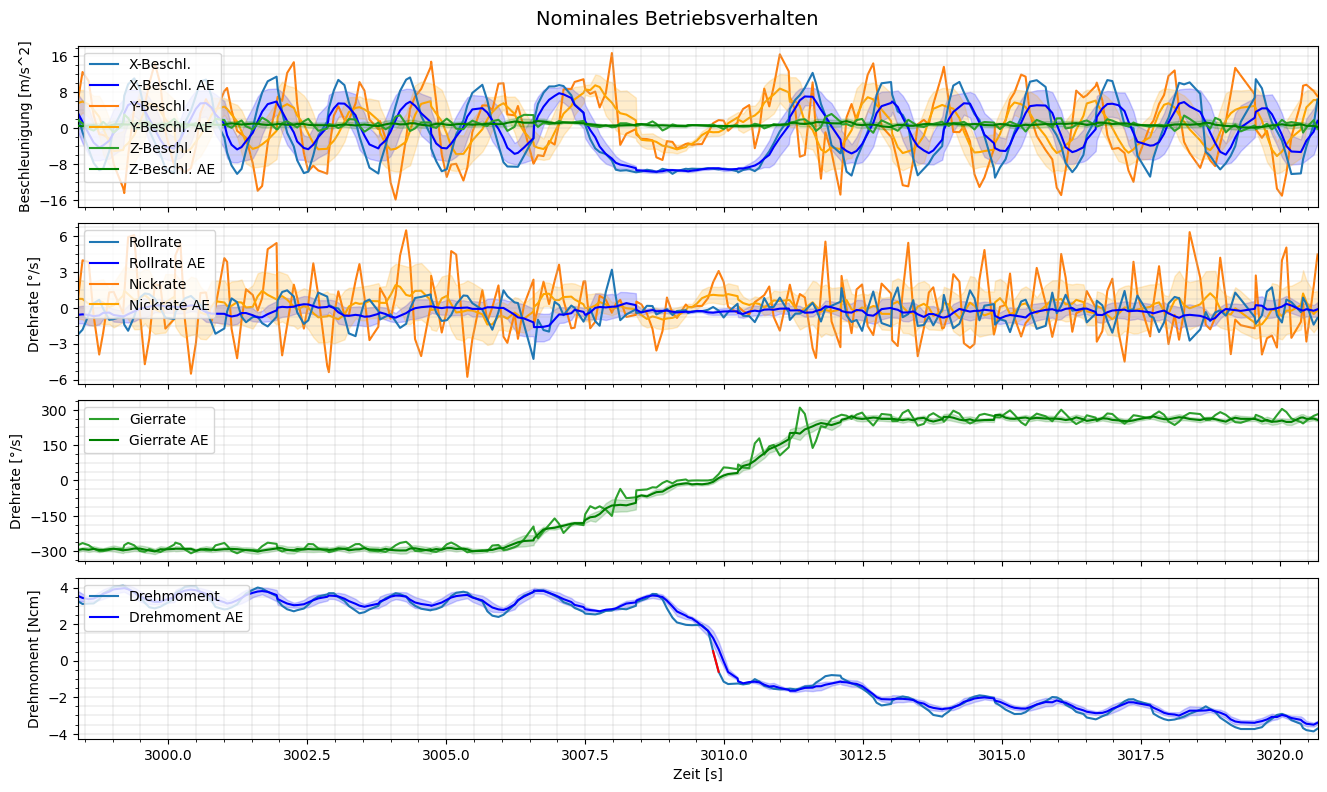

In [32]:
title_string = 'Nominales Betriebsverhalten'
save_directory = 'Anomalie-Detektion'
plot_anomalies(original_df, predicted_df, mae_df, anomaly_masks_df, x_min, x_max, title_string, save_directory, True)

# Get the anomalous data

In [33]:
urls = [
    'https://raw.githubusercontent.com/JPyschny/EIM_Autoencoder/main/2023-06-30_15-51-48_Lock%20motor.csv',
    'https://raw.githubusercontent.com/JPyschny/EIM_Autoencoder/main/2023-06-30_17-05-50_Lock%20motor.csv',
    'https://raw.githubusercontent.com/JPyschny/EIM_Autoencoder/main/2023-06-30_13-17-03_Test%20run%20unloaded.csv',
    'https://raw.githubusercontent.com/JPyschny/EIM_Autoencoder/main/2023-06-30_14-43-16_Test%20run%20loaded.csv',
    'https://raw.githubusercontent.com/JPyschny/EIM_Autoencoder/main/2023-06-30_17-17-14_Slide.csv',
    'https://raw.githubusercontent.com/JPyschny/EIM_Autoencoder/main/2023-06-30_17-20-48_Slide.csv',
    'https://raw.githubusercontent.com/JPyschny/EIM_Autoencoder/main/2023-06-30_17-27-17_Slide%20unloaded.csv',
    'https://raw.githubusercontent.com/JPyschny/EIM_Autoencoder/main/2023-06-30_17-30-39_Slide%20lock%20motor.csv',
    'https://raw.githubusercontent.com/JPyschny/EIM_Autoencoder/main/2023-07-11_13-09-57_Unbalance.csv'
]

variable_names = [
    'lockMotor1',
    'lockMotor2',
    'testRunUnloaded',
    'testRunLoaded',
    'slide1',
    'slide2',
    'slideUnloaded',
    'slideLockMotor',
    'unbalance'
]

preprocess_dataframes(urls, variable_names)

Processing DataFrame lockMotor1:
Missing values:
 Time[s]             0
RateRoll[deg/s]     0
RatePitch[deg/s]    0
RateYaw[deg/s]      0
AccX[m/s^2]         0
AccY[m/s^2]         0
AccZ[m/s^2]         0
Torque[Ncm]         0
dtype: int64
Number of duplicate rows: 0 

Number of duplicate time stamp rows: 8 

Number of rows removed because of duplicate time stamps: 8 

Processing DataFrame lockMotor2:
Missing values:
 Time[s]             0
RateRoll[deg/s]     0
RatePitch[deg/s]    0
RateYaw[deg/s]      0
AccX[m/s^2]         0
AccY[m/s^2]         0
AccZ[m/s^2]         0
Torque[Ncm]         0
dtype: int64
Number of duplicate rows: 0 

Number of duplicate time stamp rows: 62 

Number of rows removed because of duplicate time stamps: 62 

Processing DataFrame testRunUnloaded:
Missing values:
 Time[s]             0
RateRoll[deg/s]     0
RatePitch[deg/s]    0
RateYaw[deg/s]      0
AccX[m/s^2]         0
AccY[m/s^2]         0
AccZ[m/s^2]         0
Torque[Ncm]         0
dtype: int64
Number of du

## Test one dataset

In [34]:
x_min = 30
x_max = 60

# Make predictions
original_df, predicted_df = generate_predictions(loadedModel, lockMotor1, x_min, x_max, training_mean, training_std, TIME_STEPS)

Number of test samples: 296
10/10 [==============================] - 0s 2ms/step


In [35]:
mae_df, predicted_df_grouped = calculate_mae_between_dfs(original_df, predicted_df, TIME_STEPS)

In [36]:
anomaly_masks_df = identify_anomalies(original_df, mae_df, thresholds)

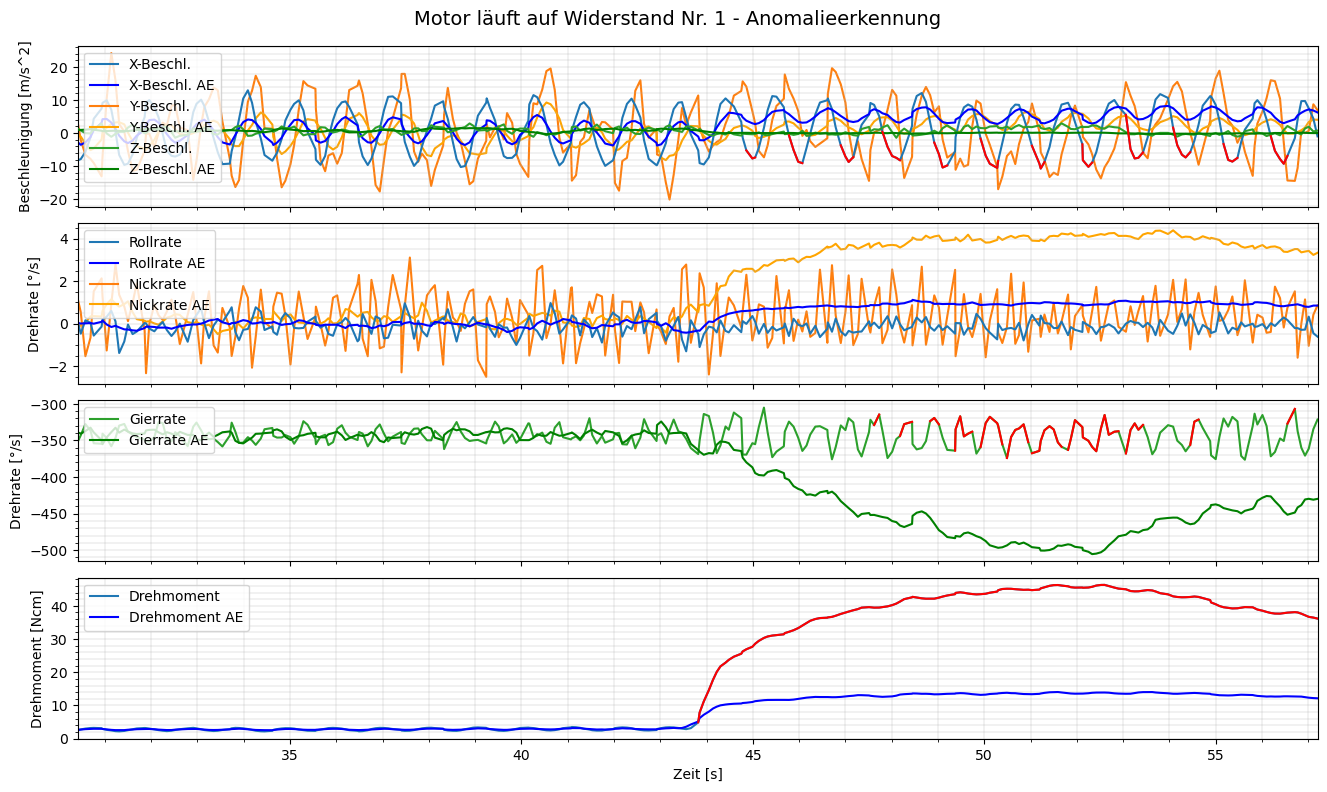

In [37]:
title_string = 'Motor läuft auf Widerstand Nr. 1 - Anomalieerkennung'
save_directory = 'Anomalie-Detektion'
plot_anomalies(original_df, predicted_df_grouped, mae_df, anomaly_masks_df, x_min, x_max, title_string, save_directory, True)

# Original Data without Anomaly Detection

Number of test samples: 188
6/6 [==============================] - 0s 2ms/step


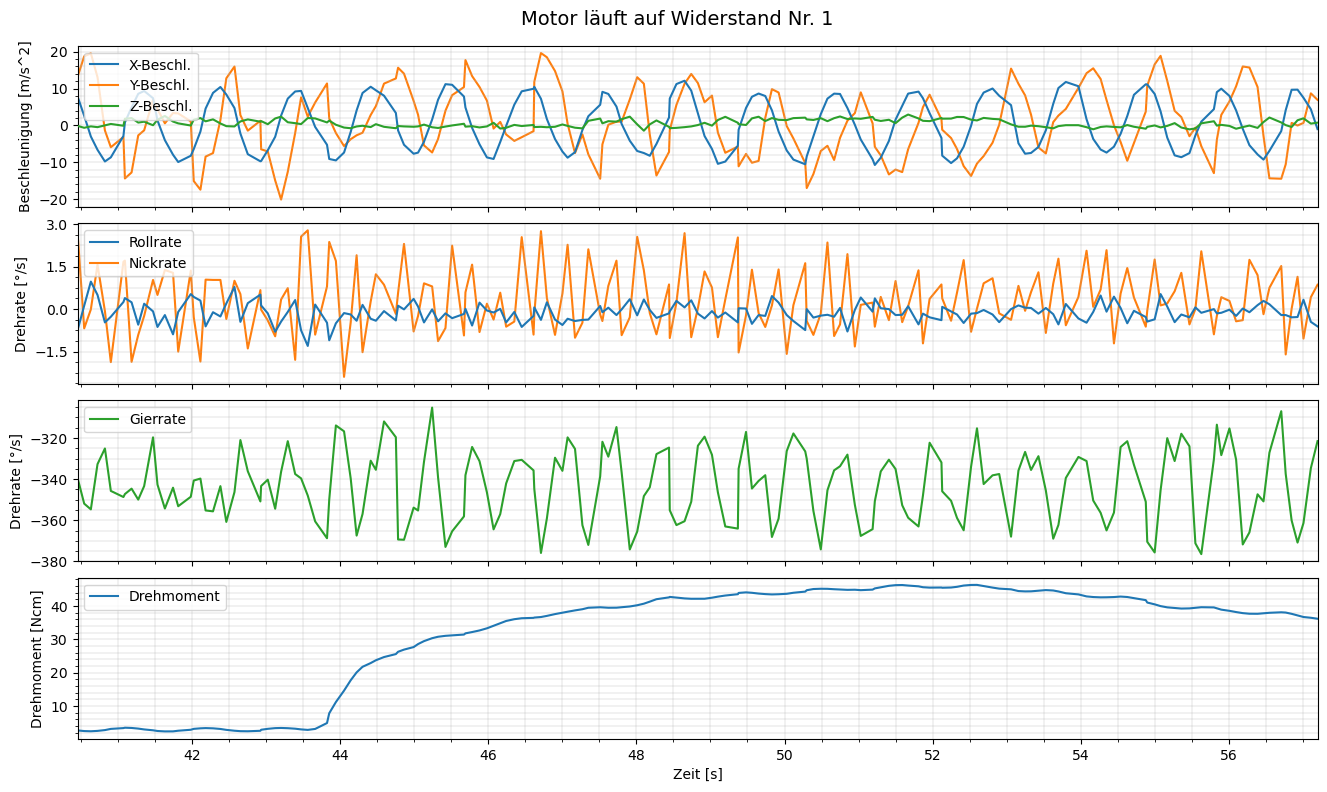

Number of test samples: 64
2/2 [==============================] - 0s 4ms/step


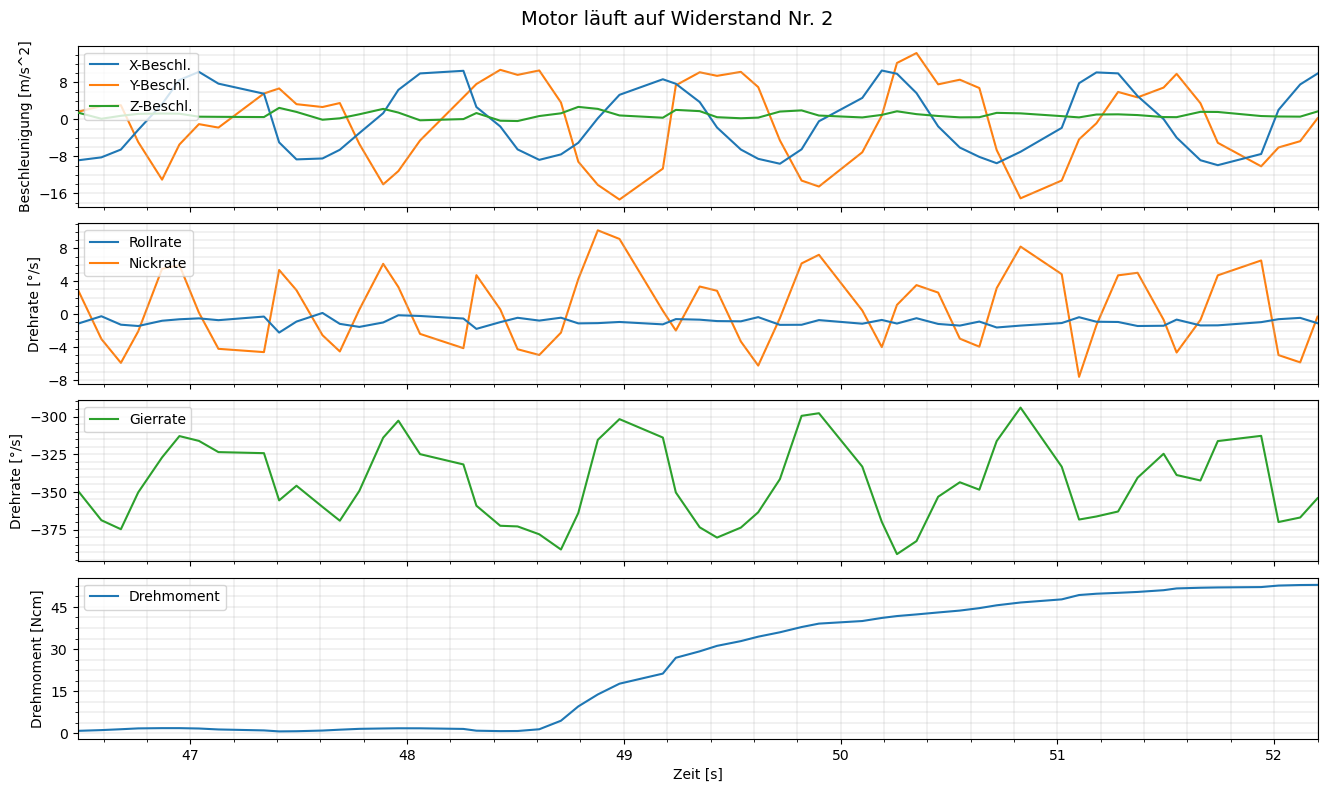

Number of test samples: 130
4/4 [==============================] - 0s 2ms/step


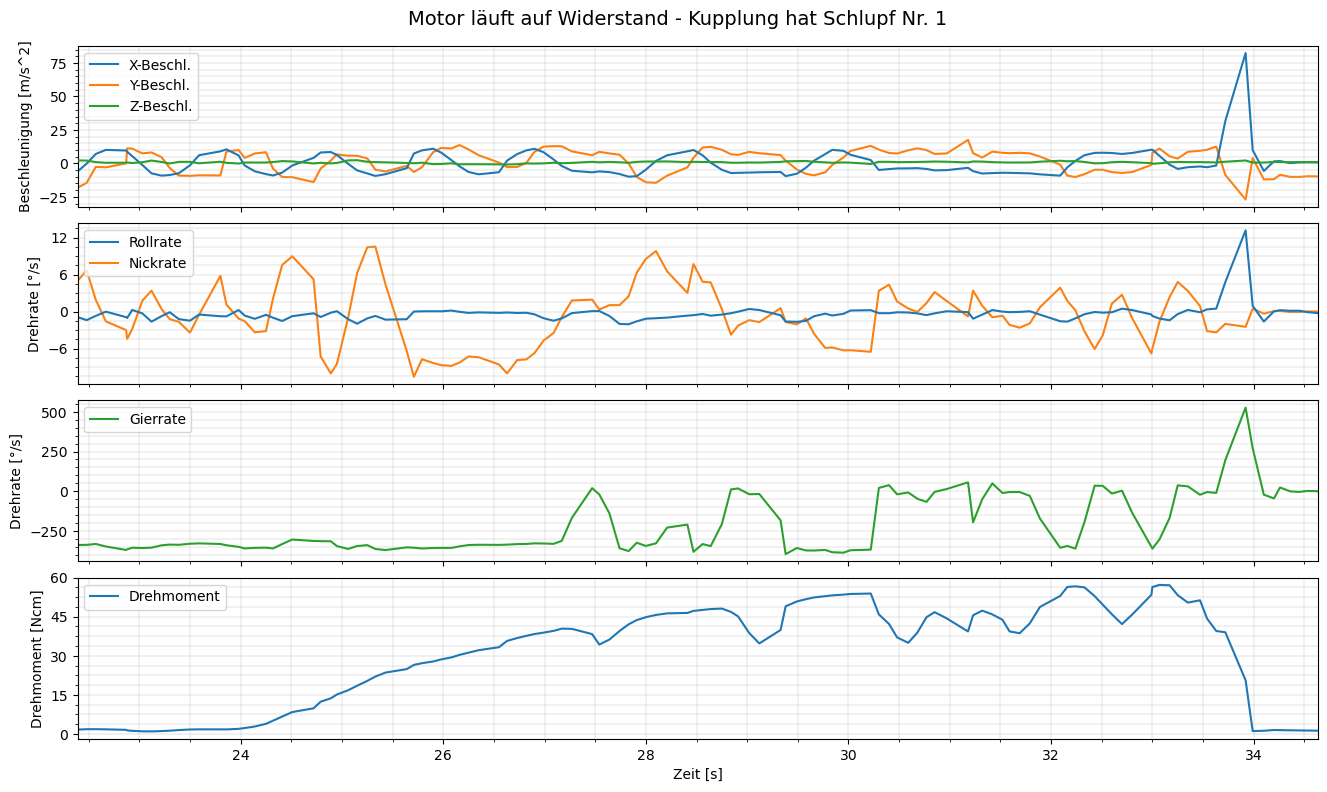

Number of test samples: 202
7/7 [==============================] - 0s 2ms/step


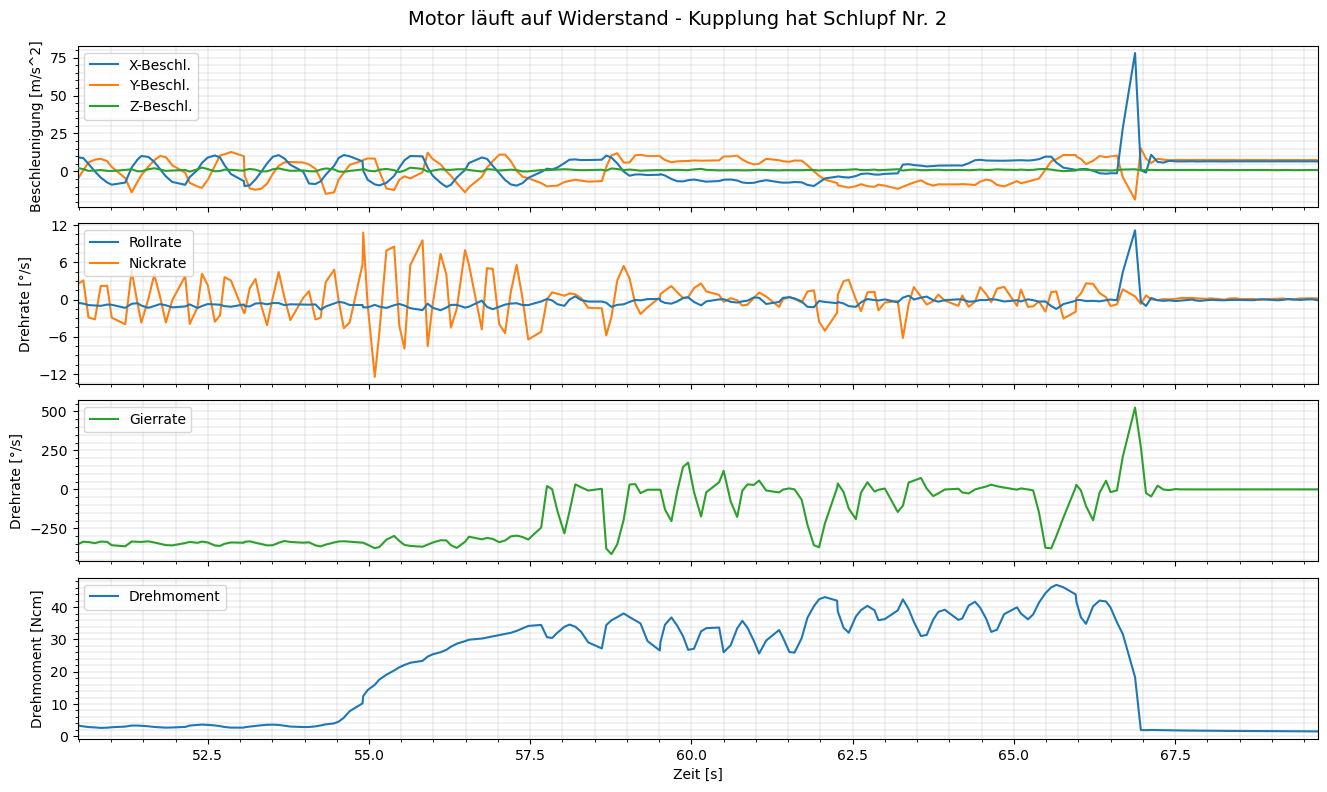

Number of test samples: 691
22/22 [==============================] - 0s 2ms/step


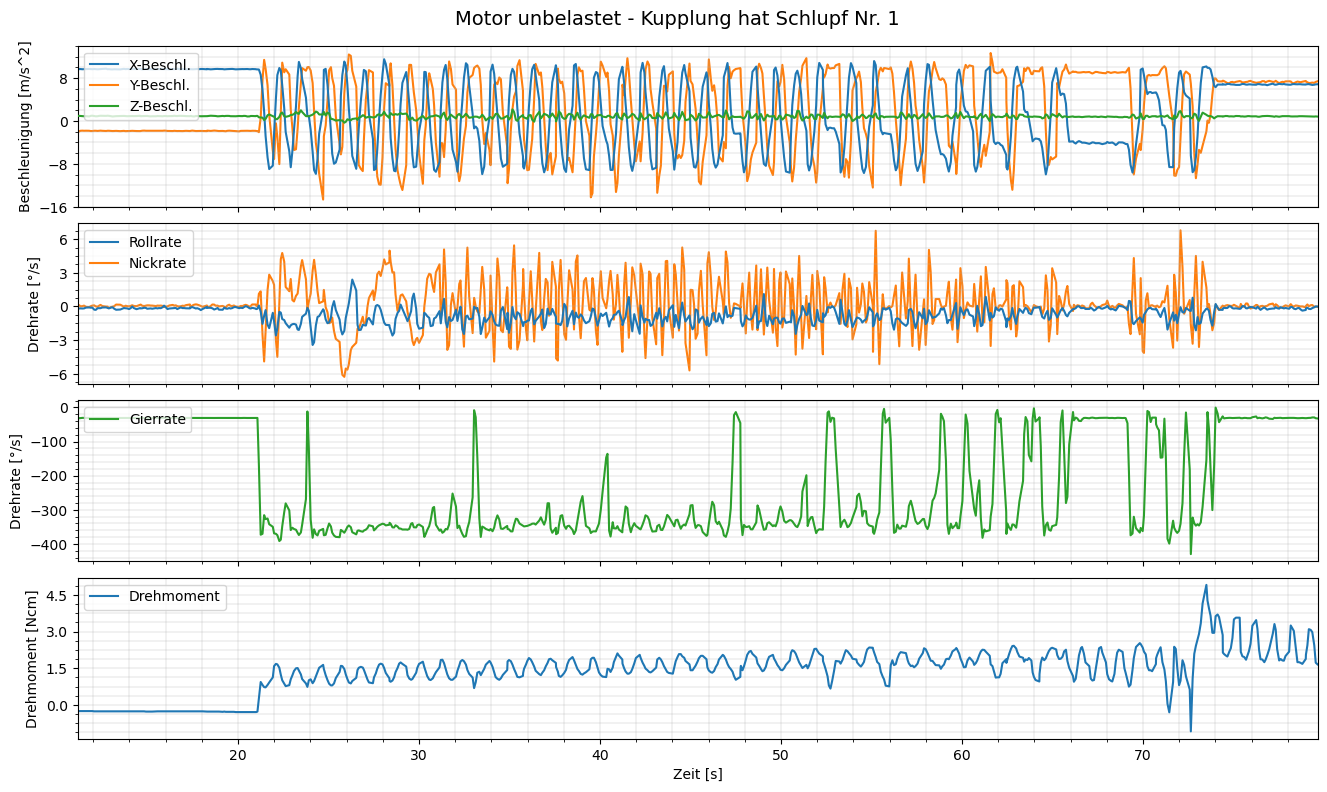

Number of test samples: 394
13/13 [==============================] - 0s 3ms/step


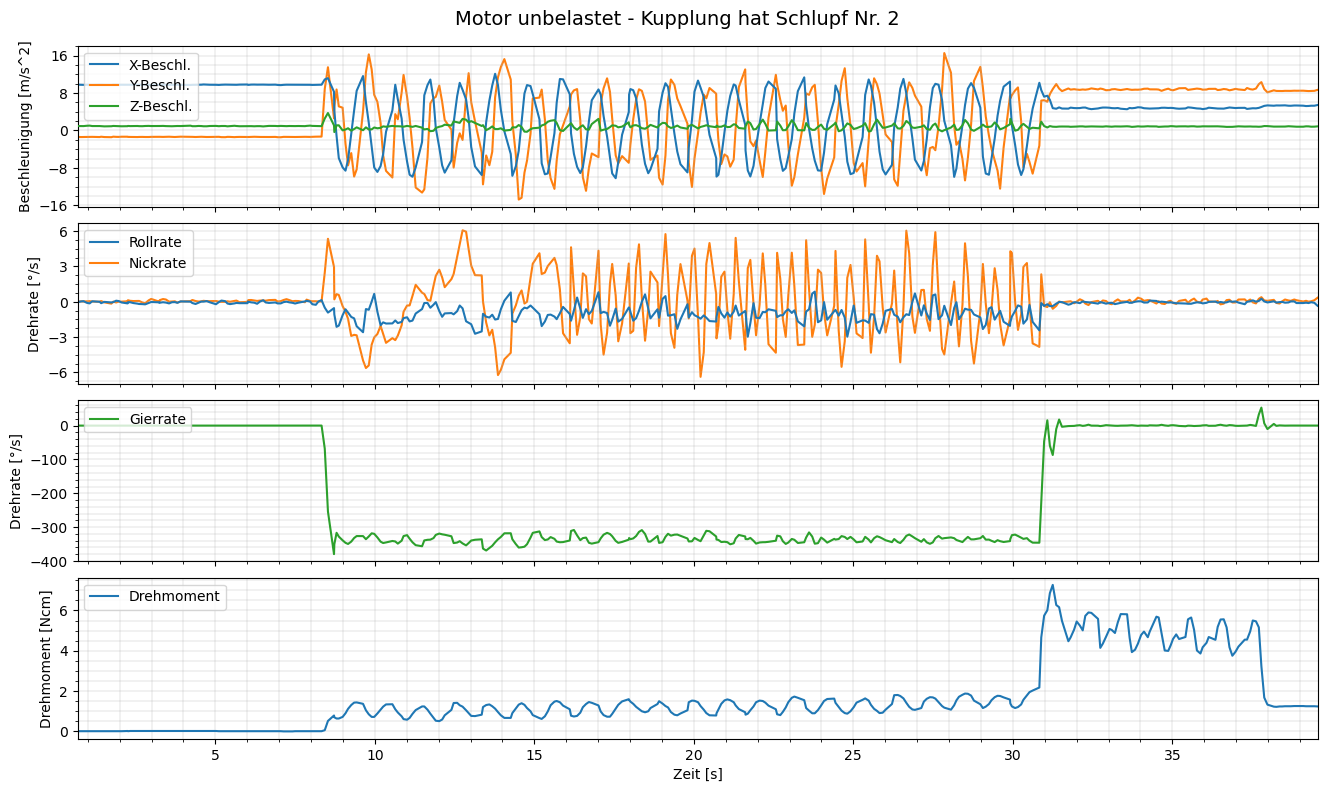

Number of test samples: 1009
32/32 [==============================] - 0s 2ms/step


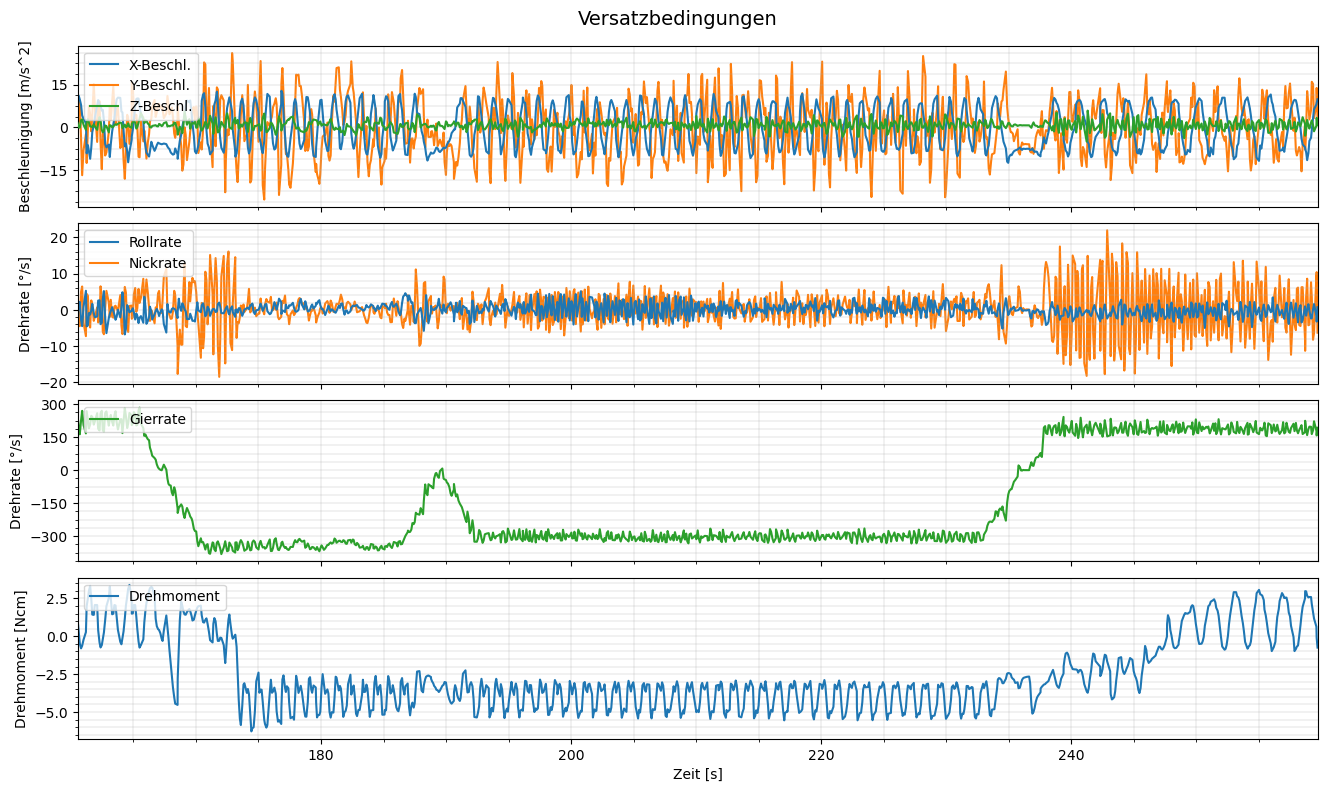

In [38]:
dataframes = [lockMotor1, lockMotor2, slide1, slide2, slideUnloaded, slideLockMotor, unbalance]
data_settings = [
    ('Motor läuft auf Widerstand Nr. 1', 40, 57.5),
    ('Motor läuft auf Widerstand Nr. 2', 46, 52.5),
    ('Motor läuft auf Widerstand - Kupplung hat Schlupf Nr. 1', 22, 35),
    ('Motor läuft auf Widerstand - Kupplung hat Schlupf Nr. 2', 50, 70),
    ('Motor unbelastet - Kupplung hat Schlupf Nr. 1', slideUnloaded['Time[s]'].min(), 80),
    ('Motor unbelastet - Kupplung hat Schlupf Nr. 2', 0, 40),
    ('Versatzbedingungen', 160, 260)
]

save_directory = 'Anomalie-Detektion-ohne-AE'

for df, (title, x_min, x_max) in zip(dataframes, data_settings):
    # predicted_df, original_df = generate_predictions(loadedModel, df, x_min, x_max, training_mean, training_std, TIME_STEPS)
    original_df, predicted_df = generate_predictions(loadedModel, df, x_min, x_max, training_mean, training_std, TIME_STEPS)
    mae_df, predicted_df_grouped = calculate_mae_between_dfs(original_df, predicted_df, TIME_STEPS)
    anomaly_masks_df = identify_anomalies(original_df, mae_df, thresholds)
    plot_anomalies(original_df, predicted_df_grouped, mae_df, anomaly_masks_df, x_min, x_max, title, save_directory, False)

# Anomaly Detection For all anomalous data sets:

Number of test samples: 188
6/6 [==============================] - 0s 3ms/step


Number of test samples: 64
2/2 [==============================] - 0s 3ms/step


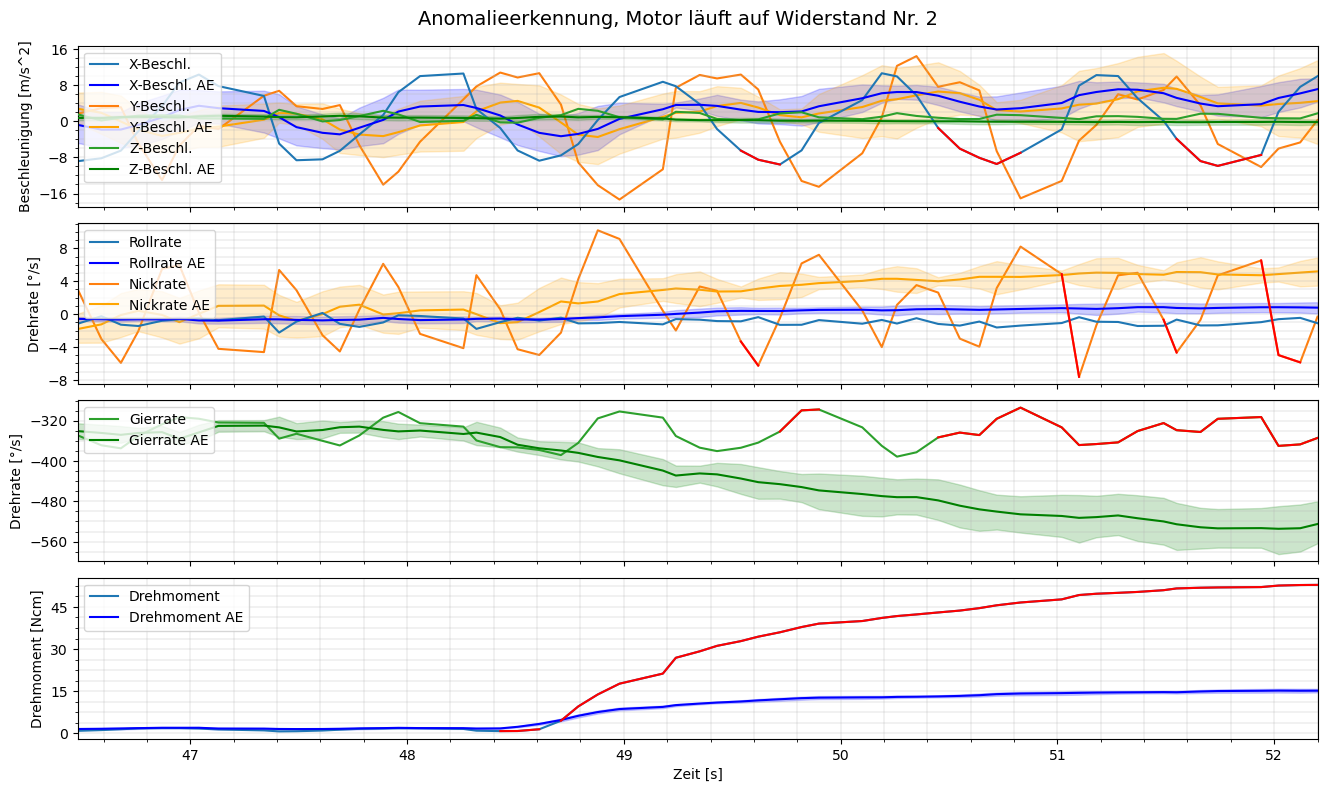

Number of test samples: 130
4/4 [==============================] - 0s 2ms/step


Number of test samples: 202
7/7 [==============================] - 0s 2ms/step


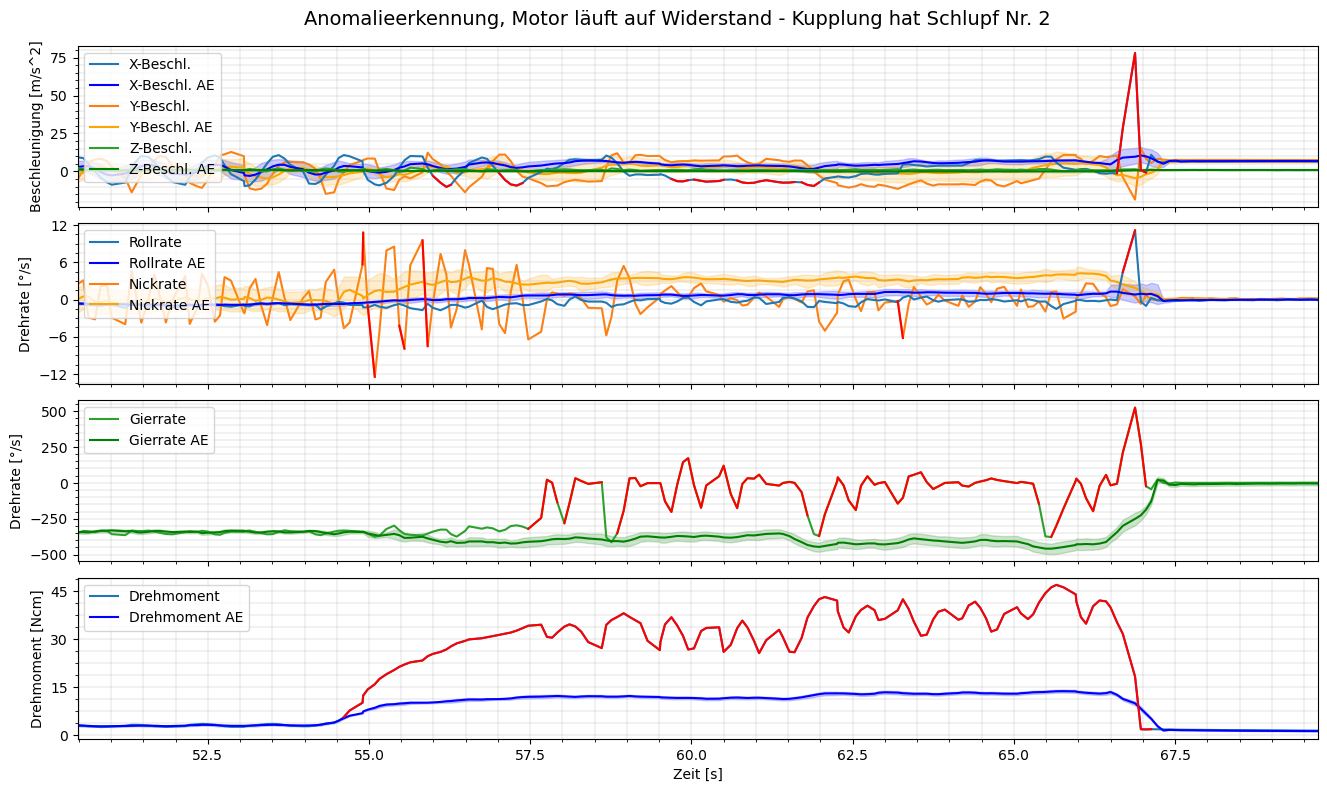

Number of test samples: 691
22/22 [==============================] - 0s 2ms/step


Number of test samples: 394
13/13 [==============================] - 0s 2ms/step


Number of test samples: 1009
32/32 [==============================] - 0s 2ms/step


In [39]:
dataframes = [lockMotor1, lockMotor2, slide1, slide2, slideUnloaded, slideLockMotor, unbalance]
data_settings = [
    ('Anomalieerkennung, Motor läuft auf Widerstand Nr. 1', 40, 57.5),
    ('Anomalieerkennung, Motor läuft auf Widerstand Nr. 2', 46, 52.5),
    ('Anomalieerkennung, Motor läuft auf Widerstand - Kupplung hat Schlupf Nr. 1', 22, 35),
    ('Anomalieerkennung, Motor läuft auf Widerstand - Kupplung hat Schlupf Nr. 2', 50, 70),
    ('Anomalieerkennung, Motor unbelastet - Kupplung hat Schlupf Nr. 1', slideUnloaded['Time[s]'].min(), 80),
    ('Anomalieerkennung, Motor unbelastet - Kupplung hat Schlupf Nr. 2', 0, 40),
    ('Anomalieerkennung, Versatzbedingungen', 160, 260)
]

save_directory = 'Anomalie-Detektion'

for df, (title, x_min, x_max) in zip(dataframes, data_settings):
    original_df, predicted_df = generate_predictions(loadedModel, df, x_min, x_max, training_mean, training_std, TIME_STEPS)
    mae_df, predicted_df_grouped = calculate_mae_between_dfs(original_df, predicted_df, TIME_STEPS)
    anomaly_masks_df = identify_anomalies(original_df, mae_df, thresholds)
    plot_anomalies(original_df, predicted_df, mae_df, anomaly_masks_df, x_min, x_max, title, save_directory, True)